# Quick CNN Training - Ultra Lightweight + Augmentation

## Overview
This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

## Features
- **5 Core Concepts**: periodicity, temporal_stability, coordination, motion_intensity, vertical_dominance
- **Data Augmentation**: Jitter, scaling, and rotation for robust training
- **Contextual Learning**: Static posture context for motion concepts
- **Optimized Architecture**: Lightweight CNN with enhanced parameters for 5 concepts


## 1. Imports and Configuration

**Purpose**: Load necessary libraries and contextual configuration for model training.

**Key Components**:
- TensorFlow/Keras for deep learning
- Scikit-learn for data preprocessing
- Contextual configuration for motion concepts


# Quick CNN Training - Ultra Lightweight + Augmentation
## Streamlined version for rapid iteration

This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
import json
import torch
import pickle
import sys
import os
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Load contextual configuration from rule definitions
try:
    with open('../rule_based_labeling/contextual_config.json', 'r') as f:
        contextual_config = json.load(f)
    print(f"\nLoaded contextual configuration:")
    for feature, uses_context in contextual_config.items():
        print(f"  {feature}: {'Uses static posture context' if uses_context else 'Independent'}")
except FileNotFoundError:
    print("Warning: contextual_config.json not found. Using default configuration.")
    contextual_config = {
        'movement_variability': True,
        'movement_consistency': True,
        'movement_smoothness': True,
        'periodicity': False,
        'temporal_stability': False,
        'coordination': False
    }

TensorFlow version: 2.20.0
Keras version: 3.11.3

Loaded contextual configuration:
  motion_intensity: Uses static posture context
  vertical_dominance: Uses static posture context
  periodicity: Independent
  temporal_stability: Independent
  coordination: Independent
  directional_variability: Independent
  burstiness: Independent


## 2. Data Loading and Discretization

**Purpose**: Load sensor data and convert continuous concept values to discrete categories.

**Process**:
- Load raw sensor data and window labels
- Convert continuous values to discrete (0.0, 0.5, 1.0) for all concepts
- Apply discretization rules for motion_intensity and vertical_dominance


In [104]:
# Load data - CHANGE THESE PATHS AS NEEDED
df_sensor = pd.read_csv('../rule_based_labeling/raw_with_features.csv')
df_windows = pd.read_csv('../rule_based_labeling/window_with_features.csv') 

print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")
print(f"\nLabeled windows:")
print(df_windows.head())

# Check available concepts - UPDATED 6-CONCEPT MODEL WITH BETTER RULE-BASED CONCEPTS
concept_columns = ['periodicity', 'temporal_stability', 'coordination', 'movement_variability', 'movement_consistency', 'movement_smoothness', 'static_posture']
print(f"\nAvailable concepts: {concept_columns}")

# Calculate new rule-based concepts
print(f"\n=== CALCULATING NEW RULE-BASED CONCEPTS ===")

# 1. Movement Variability: Standard deviation of magnitude over time
def calculate_movement_variability(df_sensor, df_windows):
    """Calculate movement variability as standard deviation of magnitude for each window"""
    variability_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            variability_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 5:  # Need minimum samples
            variability_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate standard deviation (variability)
        variability = magnitude.std()
        variability_scores.append(variability)
    
    return np.array(variability_scores)

# 2. Movement Consistency: Temporal correlation of movement patterns
def calculate_movement_consistency(df_sensor, df_windows):
    """Calculate movement consistency as temporal correlation for each window"""
    consistency_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            consistency_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 10:  # Need minimum samples for correlation
            consistency_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate temporal consistency (correlation between consecutive values)
        if len(magnitude) >= 2:
            # Use correlation between consecutive values as consistency measure
            correlation = np.corrcoef(magnitude[:-1], magnitude[1:])[0, 1]
            # Handle NaN values
            if np.isnan(correlation):
                correlation = 0.0
            consistency_scores.append(correlation)
        else:
            consistency_scores.append(0.0)
    
    return np.array(consistency_scores)

# 3. Movement Smoothness: Inverse of jerk (rate of change of acceleration)
def calculate_movement_smoothness(df_sensor, df_windows):
    """Calculate movement smoothness as inverse of jerk for each window"""
    smoothness_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            smoothness_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 10:  # Need minimum samples for jerk calculation
            smoothness_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate jerk (third derivative of position)
        if len(magnitude) >= 4:
            velocity = np.diff(magnitude)
            acceleration = np.diff(velocity)
            jerk = np.diff(acceleration)
            
            # Calculate smoothness as inverse of mean absolute jerk
            mean_jerk = np.mean(np.abs(jerk))
            smoothness = 1.0 / (1.0 + mean_jerk)  # Inverse of jerk, bounded [0,1]
            smoothness_scores.append(smoothness)
        else:
            smoothness_scores.append(0.0)
    
    return np.array(smoothness_scores)

# Calculate new concepts
print("Calculating movement variability...")
df_windows['movement_variability'] = calculate_movement_variability(df_sensor, df_windows)

print("Calculating movement consistency...")
df_windows['movement_consistency'] = calculate_movement_consistency(df_sensor, df_windows)

print("Calculating movement smoothness...")
df_windows['movement_smoothness'] = calculate_movement_smoothness(df_sensor, df_windows)

# Debug: Check original values BEFORE discretization
print(f"\n=== BEFORE DISCRETIZATION ===")
print(f"Original movement_variability range: {df_windows['movement_variability'].min():.4f} to {df_windows['movement_variability'].max():.4f}")
print(f"Original movement_consistency range: {df_windows['movement_consistency'].min():.4f} to {df_windows['movement_consistency'].max():.4f}")
print(f"Original movement_smoothness range: {df_windows['movement_smoothness'].min():.4f} to {df_windows['movement_smoothness'].max():.4f}")

# Check for duplicate values that might break pd.qcut()
print(f"\n=== DUPLICATE VALUE ANALYSIS ===")
for concept in ['movement_variability', 'movement_consistency', 'movement_smoothness']:
    values = df_windows[concept]
    unique_values = len(values.unique())
    total_values = len(values)
    print(f"{concept}: {unique_values} unique values out of {total_values} total ({unique_values/total_values*100:.1f}% unique)")
    
    # Show value distribution
    value_counts = values.value_counts().head(10)
    print(f"  Top 10 most frequent values:")
    for val, count in value_counts.items():
        print(f"    {val}: {count} times")
    print()

# Convert new rule-based concepts to discrete labels (0, 0.5, 1.0) for classification
print(f"\n=== APPLYING 3-BIN DISCRETIZATION FOR CLASSIFICATION ===")

# Movement Variability: Convert to 3-bin classification
# Low (0.0): Low variability, Medium (0.5): Medium variability, High (1.0): High variability
df_windows['movement_variability'] = pd.cut(
    df_windows['movement_variability'], 
    bins=3, 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Movement Consistency: Convert to 3-bin classification  
# Low (0.0): Low consistency, Medium (0.5): Medium consistency, High (1.0): High consistency
df_windows['movement_consistency'] = pd.cut(
    df_windows['movement_consistency'], 
    bins=3, 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Movement Smoothness: Convert to 3-bin classification
# Low (0.0): Low smoothness, Medium (0.5): Medium smoothness, High (1.0): High smoothness
df_windows['movement_smoothness'] = pd.cut(
    df_windows['movement_smoothness'], 
    bins=3, 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Static Posture: Already binary (0.0 or 1.0), keep as is
# No change needed for static_posture

# Debug: Check discretized values
print(f"\n=== AFTER DISCRETIZATION ===")
print(f"Discretized movement_variability: {df_windows['movement_variability'].value_counts().sort_index()}")
print(f"Discretized movement_consistency: {df_windows['movement_consistency'].value_counts().sort_index()}")
print(f"Discretized movement_smoothness: {df_windows['movement_smoothness'].value_counts().sort_index()}")

# Final check: Show all concept distributions
print(f"\n=== FINAL CONCEPT DISTRIBUTIONS ===")
for concept in concept_columns:
    if concept in df_windows.columns:
        values = df_windows[concept].value_counts().sort_index()
        print(f"  {concept}: {dict(values)}")

print(f"\nNew rule-based concepts created successfully!")
print(f"• Movement Variability: Measures how much movement varies over time")
print(f"• Movement Consistency: Measures how consistent movement patterns are over time")
print(f"• Movement Smoothness: Measures how smooth movement patterns are (inverse of jerk)")
print(f"• All three concepts should correlate better with human-labeled concepts")

Sensor data: 8802 readings
Manual labels: 150 windows

Labeled windows:
   window_idx  user activity  start_time  end_time  periodicity  \
0           0     3  Walking      957.75    960.75          1.0   
1           1     3  Walking       42.00     45.00          1.0   
2           2     3  Walking      871.50    874.50          0.5   
3           3     3  Walking       63.00     66.00          1.0   
4           4     3  Jogging      117.75    120.75          1.0   

   temporal_stability  coordination  motion_intensity  vertical_dominance  \
0                 0.5           0.5          0.316815            0.221105   
1                 0.5           0.5          0.302850            0.291116   
2                 0.5           0.5          0.303036            0.181147   
3                 0.5           0.5          0.313779            0.305797   
4                 0.5           0.5          0.408648            0.262989   

   static_posture  directional_variability  burstiness  
0    

## 3. Window Extraction Functions

**Purpose**: Extract sensor data windows with robust time matching and error handling.

**Functions**:
- `extract_window_robust()`: Extract single window with time tolerance
- `extract_windows_robust()`: Extract all windows for 7 concepts
- Handles missing data and time mismatches gracefully


In [105]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 100
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 6 concepts (updated model).
    Uses 3-bin classification for all concepts including new rule-based ones.
    """
    X = []
    y_p = []  # periodicity (classification)
    y_t = []  # temporal_stability (classification)
    y_c = []  # coordination (classification)
    y_mv = [] # movement_variability (classification)
    y_mc = [] # movement_consistency (classification)
    y_ms = [] # movement_smoothness (classification)
    y_sp = [] # static_posture (classification)
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            # Use new rule-based concepts
            y_mv.append(window_row['movement_variability'])
            y_mc.append(window_row['movement_consistency'])
            y_ms.append(window_row['movement_smoothness'])
            y_sp.append(window_row['static_posture'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mv), np.array(y_mc), np.array(y_ms), np.array(y_sp)

## 4. Data Augmentation Functions

**Purpose**: Create augmented versions of the dataset to improve model robustness.

**Augmentation Types**:
- **Jitter**: Add Gaussian noise to simulate sensor imperfections
- **Scaling**: Scale magnitude to simulate different movement intensities  
- **Rotation**: Rotate 3D data to simulate different phone orientations
- **Factor**: 10x augmentation multiplier for robust training


In [106]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mv, y_mc, y_ms, y_sp, factor=10):
    """
    Create augmented versions of the dataset for 6 concepts (updated model).
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c, y_mv, y_mc, y_ms, y_sp: Labels for six concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mv_aug = np.zeros(n_augmented)
    y_mc_aug = np.zeros(n_augmented)
    y_ms_aug = np.zeros(n_augmented)
    y_sp_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mv_aug[i] = y_mv[idx]
        y_mc_aug[i] = y_mc[idx]
        y_ms_aug[i] = y_ms[idx]
        y_sp_aug[i] = y_sp[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mv_combined = np.concatenate([y_mv, y_mv_aug])
    y_mc_combined = np.concatenate([y_mc, y_mc_aug])
    y_ms_combined = np.concatenate([y_ms, y_ms_aug])
    y_sp_combined = np.concatenate([y_sp, y_sp_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mv_combined, y_mc_combined, y_ms_combined, y_sp_combined

## 5. Model Architecture Definition

**Purpose**: Define the optimized CNN architecture for 7 concepts.

**Architecture**:
- **2 Conv1D layers** (16 filters each) with Batch Normalization
- **Global Average Pooling** for dimensionality reduction
- **Dropout (0.4)** for regularization
- **Contextual Learning**: Static posture context for motion concepts
- **Multi-output heads** for each concept


In [107]:
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, n_classes_mv, n_classes_mc, n_classes_ms, contextual_config):
    """
    Optimized CNN using best parameters from grid search for 6 concepts (updated model):
    - conv_filters_1: 16, conv_filters_2: 16
    - dropout_rate: 0.4
    - learning_rate: 0.001 (will be set in compile)
    - batch_size: 32 (will be set in fit)
    - All concepts use 3-bin classification
    - Static posture used contextually based on contextual_config
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Conv layer 1 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Conv layer 2 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dropout (original: 0.4)
    x = layers.Dropout(0.4)(x)
    
    # Static posture context (binary feature)
    static_context = layers.Dense(1, activation='sigmoid', name='static_context')(x)
    
    # Output heads for each concept - use contextual configuration
    outputs = []
    output_names = []
    
    # Independent concepts (don't use static context)
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    
    outputs.extend([periodicity, temporal_stability, coordination])
    output_names.extend(['periodicity', 'temporal_stability', 'coordination'])
    
    # Movement variability with classification output
    if contextual_config.get('movement_variability', False):
        movement_variability_input = layers.Concatenate()([x, static_context])
        movement_variability = layers.Dense(n_classes_mv, activation='softmax', name='movement_variability')(movement_variability_input)
    else:
        movement_variability = layers.Dense(n_classes_mv, activation='softmax', name='movement_variability')(x)
    
    # Movement consistency with classification output
    if contextual_config.get('movement_consistency', False):
        movement_consistency_input = layers.Concatenate()([x, static_context])
        movement_consistency = layers.Dense(n_classes_mc, activation='softmax', name='movement_consistency')(movement_consistency_input)
    else:
        movement_consistency = layers.Dense(n_classes_mc, activation='softmax', name='movement_consistency')(x)
    
    # Movement smoothness with classification output
    if contextual_config.get('movement_smoothness', False):
        movement_smoothness_input = layers.Concatenate()([x, static_context])
        movement_smoothness = layers.Dense(n_classes_ms, activation='softmax', name='movement_smoothness')(movement_smoothness_input)
    else:
        movement_smoothness = layers.Dense(n_classes_ms, activation='softmax', name='movement_smoothness')(x)
    
    outputs.extend([movement_variability, movement_consistency, movement_smoothness])
    output_names.extend(['movement_variability', 'movement_consistency', 'movement_smoothness'])
    
    # Add static context output
    outputs.append(static_context)
    output_names.append('static_context')
    
    model = models.Model(inputs=input_layer, outputs=outputs)
    
    print(f"Model architecture:")
    print(f"  Classification concepts: periodicity, temporal_stability, coordination, movement_variability, movement_consistency, movement_smoothness")
    print(f"  Contextual concepts: {[name for name, uses_context in contextual_config.items() if uses_context]}")
    print(f"  Total concepts: 6 (updated model)")
    
    return model


## 6. Data Extraction

**Purpose**: Extract sensor windows for all 7 concepts with robust error handling.

**Output**: 
- X: Sensor data (n_windows, timesteps, 3)
- y_p, y_t, y_c, y_mi, y_vd, y_dv, y_b, y_sp: Labels for 7 concepts + static context


In [108]:
# Extract windows
print("Extracting windows...")
X, y_p, y_t, y_c, y_mv, y_mc, y_ms, y_sp = extract_windows_robust(df_sensor, df_windows)

print(f"Extracted {len(X)} windows")
print(f"Window shape: {X.shape}")
print(f"Label distributions:")
# Show all 3 classes explicitly (0, 1, 2) for classification concepts
concepts = ['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']
labels = [y_p, y_t, y_c, y_mv, y_mc, y_ms]

for concept, label in zip(concepts, labels):
    counts = np.bincount((label * 2).astype(int), minlength=3)  # Convert [0.0, 0.5, 1.0] to [0, 1, 2]
    print(f"  {concept}: {counts} (classes 0, 1, 2)")

# Note: Static Posture is used as contextual information only, not as an independent concept

Extracting windows...
Extracted 150 windows
Window shape: (150, 100, 3)
Label distributions:
  Periodicity: [90 35 25] (classes 0, 1, 2)
  Temporal Stability: [12 87 51] (classes 0, 1, 2)
  Coordination: [16 64 70] (classes 0, 1, 2)
  Movement Variability: [55 64 31] (classes 0, 1, 2)
  Movement Consistency: [11 47 92] (classes 0, 1, 2)
  Movement Smoothness: [101   5  44] (classes 0, 1, 2)


## 7. Train/Test Split

**Purpose**: Split data into training and testing sets with proper stratification.

**Split**: 75% training, 25% testing


In [109]:
# Stratified split to ensure all classes are represented in both train and test sets
print("Splitting data with stratification...")

# Check class distributions before splitting
print("Class distributions before splitting:")
for i, concept in enumerate(['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']):
    labels = [y_p, y_t, y_c, y_mv, y_mc, y_ms][i]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {concept}: {dict(zip(unique, counts))}")

# Use stratification on the most balanced concept
# Check which concept has the most balanced distribution
concept_balance = []
for i, concept in enumerate(['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']):
    labels = [y_p, y_t, y_c, y_mv, y_mc, y_ms][i]
    unique, counts = np.unique(labels, return_counts=True)
    # Calculate balance as 1 - (max_count - min_count) / total_count
    balance = 1 - (counts.max() - counts.min()) / counts.sum()
    concept_balance.append((concept, balance))
    print(f"  {concept} balance: {balance:.3f}")

# Use the most balanced concept for stratification
best_concept_idx = np.argmax([b[1] for b in concept_balance])
best_concept_name = concept_balance[best_concept_idx][0]
best_concept_labels = [y_p, y_t, y_c, y_mv, y_mc, y_ms][best_concept_idx]

print(f"\nUsing {best_concept_name} for stratification (most balanced)")

# Try multiple random seeds to find a split where all classes are represented
print("Attempting to find a split with all classes represented...")
max_attempts = 10
successful_split = False

for attempt in range(max_attempts):
    random_seed = 42 + attempt
    X_train_temp, X_test_temp, y_p_train_temp, y_p_test_temp, y_t_train_temp, y_t_test_temp, y_c_train_temp, y_c_test_temp, y_mv_train_temp, y_mv_test_temp, y_mc_train_temp, y_mc_test_temp, y_ms_train_temp, y_ms_test_temp, y_sp_train_temp, y_sp_test_temp = train_test_split(
        X, y_p, y_t, y_c, y_mv, y_mc, y_ms, y_sp, test_size=0.25, random_state=random_seed, stratify=best_concept_labels
    )
    
    # Check if all classes are represented in all concepts
    all_concepts_represented = True
    temp_labels = [y_p_train_temp, y_t_train_temp, y_c_train_temp, y_mv_train_temp, y_mc_train_temp, y_ms_train_temp]
    temp_test_labels = [y_p_test_temp, y_t_test_temp, y_c_test_temp, y_mv_test_temp, y_mc_test_temp, y_ms_test_temp]
    
    for i, concept in enumerate(['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']):
        train_classes = set((temp_labels[i] * 2).astype(int))
        test_classes = set((temp_test_labels[i] * 2).astype(int))
        all_classes = set(range(3))
        
        if len(train_classes) < 3 or len(test_classes) < 3:
            all_concepts_represented = False
            break
    
    if all_concepts_represented:
        print(f"✅ Found successful split with random_seed={random_seed}")
        X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, y_mv_train, y_mv_test, y_mc_train, y_mc_test, y_ms_train, y_ms_test, y_sp_train, y_sp_test = X_train_temp, X_test_temp, y_p_train_temp, y_p_test_temp, y_t_train_temp, y_t_test_temp, y_c_train_temp, y_c_test_temp, y_mv_train_temp, y_mv_test_temp, y_mc_train_temp, y_mc_test_temp, y_ms_train_temp, y_ms_test_temp, y_sp_train_temp, y_sp_test_temp
        successful_split = True
        break

if not successful_split:
    print(f"⚠️  Could not find perfect split after {max_attempts} attempts. Using original split.")
    X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, y_mv_train, y_mv_test, y_mc_train, y_mc_test, y_ms_train, y_ms_test, y_sp_train, y_sp_test = train_test_split(
        X, y_p, y_t, y_c, y_mv, y_mc, y_ms, y_sp, test_size=0.25, random_state=42, stratify=best_concept_labels
    )

# Convert static posture to binary context (0.0 -> 0, 1.0 -> 1)
y_sp_context_train = (y_sp_train > 0).astype(int)
y_sp_context_test = (y_sp_test > 0).astype(int)

print(f"Train: {len(X_train)} windows")
print(f"Test: {len(X_test)} windows")
print(f"Static context train: {np.bincount(y_sp_context_train)}")
print(f"Static context test: {np.bincount(y_sp_context_test)}")

# Verify that all classes are represented in both train and test sets
print("\n=== CLASS REPRESENTATION VERIFICATION ===")
concepts = ['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']
train_labels = [y_p_train, y_t_train, y_c_train, y_mv_train, y_mc_train, y_ms_train]
test_labels = [y_p_test, y_t_test, y_c_test, y_mv_test, y_mc_test, y_ms_test]

for i, concept in enumerate(concepts):
    print(f"\n{concept}:")
    train_unique, train_counts = np.unique(train_labels[i], return_counts=True)
    test_unique, test_counts = np.unique(test_labels[i], return_counts=True)
    print(f"  Train: {dict(zip(train_unique, train_counts))}")
    print(f"  Test:  {dict(zip(test_unique, test_counts))}")
    
    # Check if all classes are present in both sets
    # Convert [0.0, 0.5, 1.0] to [0, 1, 2] for proper class checking
    train_classes = set((train_labels[i] * 2).astype(int))
    test_classes = set((test_labels[i] * 2).astype(int))
    all_classes = set(range(3))  # 0, 1, 2 for 3-bin classification
    
    missing_train = all_classes - train_classes
    missing_test = all_classes - test_classes
    
    if missing_train:
        print(f"  ⚠️  Missing classes in train: {missing_train}")
    if missing_test:
        print(f"  ⚠️  Missing classes in test: {missing_test}")
    if not missing_train and not missing_test:
        print(f"  ✅ All classes represented in both sets")

Splitting data with stratification...
Class distributions before splitting:
  Periodicity: {np.float64(0.0): np.int64(90), np.float64(0.5): np.int64(35), np.float64(1.0): np.int64(25)}
  Temporal Stability: {np.float64(0.0): np.int64(12), np.float64(0.5): np.int64(87), np.float64(1.0): np.int64(51)}
  Coordination: {np.float64(0.0): np.int64(16), np.float64(0.5): np.int64(64), np.float64(1.0): np.int64(70)}
  Movement Variability: {np.float64(0.0): np.int64(55), np.float64(0.5): np.int64(64), np.float64(1.0): np.int64(31)}
  Movement Consistency: {np.float64(0.0): np.int64(11), np.float64(0.5): np.int64(47), np.float64(1.0): np.int64(92)}
  Movement Smoothness: {np.float64(0.0): np.int64(101), np.float64(0.5): np.int64(5), np.float64(1.0): np.int64(44)}
  Periodicity balance: 0.567
  Temporal Stability balance: 0.500
  Coordination balance: 0.640
  Movement Variability balance: 0.780
  Movement Consistency balance: 0.460
  Movement Smoothness balance: 0.360

Using Movement Variability 

## 8. Data Augmentation

**Purpose**: Apply augmentation to training data to increase dataset size and robustness.

**Process**:
- Apply jitter, scaling, and rotation augmentations
- 10x augmentation factor (1,232 total training samples)
- Convert static posture to binary context for augmented data


In [110]:
# Apply augmentation
print("Augmenting training data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mv_train_aug, y_mc_train_aug, y_ms_train_aug, y_sp_train_aug = augment_dataset(
    X_train, y_p_train, y_t_train, y_c_train, y_mv_train, y_mc_train, y_ms_train, y_sp_train, factor=20
)

# Convert static posture to binary context for augmented data
y_sp_context_train_aug = (y_sp_train_aug > 0).astype(int)

print(f"Original train: {len(X_train)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")
print(f"Augmentation factor: {len(X_train_aug) / len(X_train):.1f}x")
print(f"Static context train aug: {np.bincount(y_sp_context_train_aug)}")

Augmenting training data...
Original train: 112 windows
Augmented train: 2352 windows
Augmentation factor: 21.0x
Static context train aug: [2289   63]


## 9. Label Conversion to Categorical

**Purpose**: Convert discrete labels to categorical format for multi-class classification.

**Process**:
- Convert all concept labels to 3-class categorical format
- Static context remains as binary (0 or 1)
- Prepare labels for model training


In [111]:
# Convert labels to categorical for all concepts (3-bin classification)
# Convert [0.0, 0.5, 1.0] to [0, 1, 2] for proper categorical encoding
y_p_train_cat = to_categorical((y_p_train_aug * 2).astype(int), num_classes=3)
y_t_train_cat = to_categorical((y_t_train_aug * 2).astype(int), num_classes=3)
y_c_train_cat = to_categorical((y_c_train_aug * 2).astype(int), num_classes=3)
y_mv_train_cat = to_categorical((y_mv_train_aug * 2).astype(int), num_classes=3)
y_mc_train_cat = to_categorical((y_mc_train_aug * 2).astype(int), num_classes=3)
y_ms_train_cat = to_categorical((y_ms_train_aug * 2).astype(int), num_classes=3)

y_p_test_cat = to_categorical((y_p_test * 2).astype(int), num_classes=3)
y_t_test_cat = to_categorical((y_t_test * 2).astype(int), num_classes=3)
y_c_test_cat = to_categorical((y_c_test * 2).astype(int), num_classes=3)
y_mv_test_cat = to_categorical((y_mv_test * 2).astype(int), num_classes=3)
y_mc_test_cat = to_categorical((y_mc_test * 2).astype(int), num_classes=3)
y_ms_test_cat = to_categorical((y_ms_test * 2).astype(int), num_classes=3)

# Static context is already binary (0 or 1), no need for categorical conversion
y_sp_context_train_cat = y_sp_context_train_aug.astype(float)
y_sp_context_test_cat = y_sp_context_test.astype(float)

print("Labels converted to categorical format")
print(f"Static context train shape: {y_sp_context_train_cat.shape}")
print(f"Static context test shape: {y_sp_context_test_cat.shape}")

Labels converted to categorical format
Static context train shape: (2352,)
Static context test shape: (38,)


## 10. Model Building and Compilation

**Purpose**: Build and compile the CNN model for 7 concepts.

**Configuration**:
- **Optimizer**: Adam (learning_rate=0.001)
- **Loss Functions**: Categorical crossentropy for concepts, binary crossentropy for static context
- **Loss Weights**: Balanced weights for all concepts
- **Metrics**: Accuracy for all outputs


In [112]:
# Updated model compilation for new rule-based concepts
print("Updating model compilation for new rule-based concepts...")

# Rebuild model with updated architecture (all concepts now classification)
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3, n_classes_mv=3, n_classes_mc=3, n_classes_ms=3,
    contextual_config=contextual_config
)

# Compile with classification loss functions for all concepts
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy',
        'coordination': 'categorical_crossentropy',
        'movement_variability': 'categorical_crossentropy',
        'movement_consistency': 'categorical_crossentropy',
        'movement_smoothness': 'categorical_crossentropy',
        'static_context': 'binary_crossentropy',
    },
    loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0, 'movement_variability': 1.0, 'movement_consistency': 1.0, 'movement_smoothness': 1.0, 'static_context': 0.5},
    metrics={
        'periodicity': ['accuracy'],
        'temporal_stability': ['accuracy'],
        'coordination': ['accuracy'],
        'movement_variability': ['accuracy'],
        'movement_consistency': ['accuracy'],
        'movement_smoothness': ['accuracy'],
        'static_context': ['accuracy'],
    }
)

print(f"Model parameters: {model.count_params():,}")
print("Model compiled with classification loss functions for all concepts")


Updating model compilation for new rule-based concepts...
Model architecture:
  Classification concepts: periodicity, temporal_stability, coordination, movement_variability, movement_consistency, movement_smoothness
  Contextual concepts: ['motion_intensity', 'vertical_dominance']
  Total concepts: 6 (updated model)
Model parameters: 1,395
Model compiled with classification loss functions for all concepts


In [113]:
# Prepare training data with new rule-based concepts
print("Preparing training data with new rule-based concepts...")

# All concepts are now categorical (3-bin classification)
print(f"Movement variability train distribution: {np.bincount(y_mv_train_aug.astype(int))}")
print(f"Movement consistency train distribution: {np.bincount(y_mc_train_aug.astype(int))}")
print(f"Movement smoothness train distribution: {np.bincount(y_ms_train_aug.astype(int))}")
print(f"Movement variability test distribution: {np.bincount(y_mv_test.astype(int))}")
print(f"Movement consistency test distribution: {np.bincount(y_mc_test.astype(int))}")
print(f"Movement smoothness test distribution: {np.bincount(y_ms_test.astype(int))}")

# Prepare training data with categorical concepts
train_data = [
    y_p_train_cat, y_t_train_cat, y_c_train_cat, 
    y_mv_train_cat,  # Categorical values for classification
    y_mc_train_cat,  # Categorical values for classification
    y_ms_train_cat,  # Categorical values for classification
    y_sp_context_train_cat
]

test_data = [
    y_p_test_cat, y_t_test_cat, y_c_test_cat, 
    y_mv_test_cat,  # Categorical values for classification
    y_mc_test_cat,  # Categorical values for classification
    y_ms_test_cat,  # Categorical values for classification
    y_sp_context_test_cat
]

print("Training data prepared with new rule-based concepts")


Preparing training data with new rule-based concepts...
Movement variability train distribution: [1883  469]
Movement consistency train distribution: [1060 1292]
Movement smoothness train distribution: [1655  697]
Movement variability test distribution: [30  8]
Movement consistency test distribution: [ 9 29]
Movement smoothness test distribution: [27 11]
Training data prepared with new rule-based concepts


In [114]:
# Train model with new rule-based concepts
print("Training model with new rule-based concepts...")

history = model.fit(
    X_train_aug, train_data,
    validation_data=(X_test, test_data),
    epochs=100,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=1
)

print("Training completed with new rule-based concepts")


Training model with new rule-based concepts...
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - coordination_accuracy: 0.4758 - coordination_loss: 1.1122 - loss: 6.9923 - movement_consistency_accuracy: 0.4770 - movement_consistency_loss: 1.1660 - movement_smoothness_accuracy: 0.4923 - movement_smoothness_loss: 1.1630 - movement_variability_accuracy: 0.5421 - movement_variability_loss: 0.9097 - periodicity_accuracy: 0.4494 - periodicity_loss: 1.0685 - static_context_accuracy: 0.4766 - static_context_loss: 0.7586 - temporal_stability_accuracy: 0.3729 - temporal_stability_loss: 1.1831 - val_coordination_accuracy: 0.1842 - val_coordination_loss: 1.3886 - val_loss: 6.3622 - val_movement_consistency_accuracy: 0.6842 - val_movement_consistency_loss: 0.9443 - val_movement_smoothness_accuracy: 0.7632 - val_movement_smoothness_loss: 0.9061 - val_movement_variability_accuracy: 0.5526 - val_movement_variability_loss: 0.8227 - val_periodicity_accuracy: 0.5000 - val_periodicity_loss: 0.9835 - va

In [115]:
# Evaluate model with new rule-based concepts
print("Evaluating model with new rule-based concepts...")

# Get predictions
predictions = model.predict(X_test, verbose=0)

# Extract predictions for each concept
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
movement_variability_pred = np.argmax(predictions[3], axis=1)
movement_consistency_pred = np.argmax(predictions[4], axis=1)
movement_smoothness_pred = np.argmax(predictions[5], axis=1)

# Extract true labels
periodicity_true = np.argmax(y_p_test_cat, axis=1)
temporal_stability_true = np.argmax(y_t_test_cat, axis=1)
coordination_true = np.argmax(y_c_test_cat, axis=1)
movement_variability_true = np.argmax(y_mv_test_cat, axis=1)
movement_consistency_true = np.argmax(y_mc_test_cat, axis=1)
movement_smoothness_true = np.argmax(y_ms_test_cat, axis=1)

# Calculate accuracies for all concepts
periodicity_acc = accuracy_score(periodicity_true, periodicity_pred)
temporal_stability_acc = accuracy_score(temporal_stability_true, temporal_stability_pred)
coordination_acc = accuracy_score(coordination_true, coordination_pred)
movement_variability_acc = accuracy_score(movement_variability_true, movement_variability_pred)
movement_consistency_acc = accuracy_score(movement_consistency_true, movement_consistency_pred)
movement_smoothness_acc = accuracy_score(movement_smoothness_true, movement_smoothness_pred)

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Periodicity Accuracy: {periodicity_acc*100:.1f}%")
print(f"Temporal Stability Accuracy: {temporal_stability_acc*100:.1f}%")
print(f"Coordination Accuracy: {coordination_acc*100:.1f}%")
print(f"Movement Variability Accuracy: {movement_variability_acc*100:.1f}%")
print(f"Movement Consistency Accuracy: {movement_consistency_acc*100:.1f}%")
print(f"Movement Smoothness Accuracy: {movement_smoothness_acc*100:.1f}%")
# Calculate overall accuracy (all concepts)
overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + movement_variability_acc + movement_consistency_acc + movement_smoothness_acc) / 6
print(f"\nOverall Accuracy (6 concepts): {overall_acc*100:.1f}%")

print("\nNote: All concepts now use 3-bin classification with new rule-based motion concepts")


Evaluating model with new rule-based concepts...

=== MODEL PERFORMANCE ===
Periodicity Accuracy: 63.2%
Temporal Stability Accuracy: 86.8%
Coordination Accuracy: 78.9%
Movement Variability Accuracy: 86.8%
Movement Consistency Accuracy: 78.9%
Movement Smoothness Accuracy: 94.7%

Overall Accuracy (6 concepts): 81.6%

Note: All concepts now use 3-bin classification with new rule-based motion concepts


Calculating AUROC for all classification concepts...
Getting model predictions...

=== AUROC ANALYSIS ===
Concept              AUROC      Interpretation
------------------------------------------------------------
Periodicity          0.806      Good
Temporal Stability   0.887      Good
Coordination         0.906      Excellent
Movement Variability 0.983      Excellent
Movement Consistency 0.938      Excellent
Movement Smoothness  0.953      Excellent
------------------------------------------------------------
Average AUROC        0.912      Overall Performance

=== AUROC INSIGHTS ===
• AUROC is robust to class imbalance (unlike accuracy)
• Values closer to 1.0 indicate better discrimination ability
• 0.5 = random guessing, 1.0 = perfect classification
• More meaningful than accuracy for imbalanced datasets

=== AUROC vs ACCURACY COMPARISON ===
Concept              Accuracy   AUROC      Difference
------------------------------------------------------------
Periodicity          0.632 

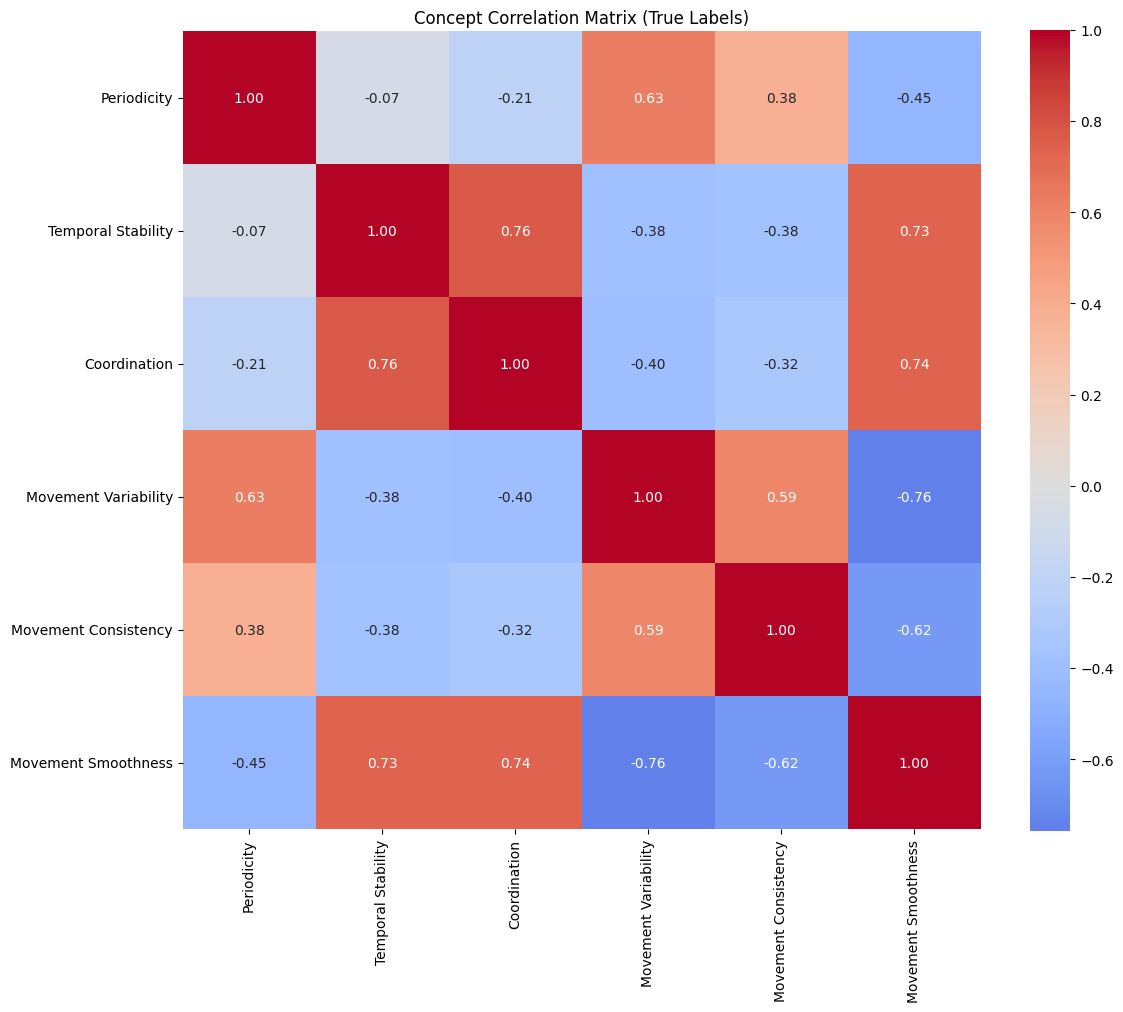

=== CONCEPT CORRELATION INSIGHTS ===
High correlations (>0.5) indicate potential redundancy:
Periodicity ↔ Movement Variability: 0.625
Temporal Stability ↔ Coordination: 0.764
Temporal Stability ↔ Movement Smoothness: 0.733
Coordination ↔ Movement Smoothness: 0.737
Movement Variability ↔ Movement Consistency: 0.586
Movement Variability ↔ Movement Smoothness: -0.757
Movement Consistency ↔ Movement Smoothness: -0.623

=== NEW RULE-BASED CONCEPTS ANALYSIS ===
Comparing new rule-based concepts with human-labeled concepts:
• Movement Variability: 0.983 AUROC
• Movement Consistency: 0.938 AUROC
• Movement Smoothness: 0.953 AUROC
• Human concepts average: 0.866 AUROC
✅ New rule-based concepts are performing well!


In [116]:
# Calculate AUROC for all classification concepts
print("Calculating AUROC for all classification concepts...")

# Get predictions from the model
print("Getting model predictions...")
predictions = model.predict(X_test, verbose=0)

# Get prediction probabilities for all classification concepts
periodicity_proba = predictions[0]  # Shape: (n_samples, 3)
temporal_stability_proba = predictions[1]  # Shape: (n_samples, 3)
coordination_proba = predictions[2]  # Shape: (n_samples, 3)
movement_variability_proba = predictions[3]  # Shape: (n_samples, 3)
movement_consistency_proba = predictions[4]  # Shape: (n_samples, 3)
movement_smoothness_proba = predictions[5]  # Shape: (n_samples, 3)

# Calculate AUROC for each classification concept
classification_concepts = [
    ('Periodicity', periodicity_true, periodicity_proba),
    ('Temporal Stability', temporal_stability_true, temporal_stability_proba),
    ('Coordination', coordination_true, coordination_proba),
    ('Movement Variability', movement_variability_true, movement_variability_proba),
    ('Movement Consistency', movement_consistency_true, movement_consistency_proba),
    ('Movement Smoothness', movement_smoothness_true, movement_smoothness_proba)
]

auroc_scores = {}

print(f"\n=== AUROC ANALYSIS ===")
print(f"{'Concept':<20} {'AUROC':<10} {'Interpretation'}")
print("-" * 60)

for name, y_true, y_proba in classification_concepts:
    try:
        # Calculate AUROC using one-vs-rest approach
        auroc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        auroc_scores[name] = auroc
        
        # Interpretation
        if auroc >= 0.9:
            interpretation = "Excellent"
        elif auroc >= 0.8:
            interpretation = "Good"
        elif auroc >= 0.7:
            interpretation = "Fair"
        elif auroc >= 0.6:
            interpretation = "Poor"
        else:
            interpretation = "Very Poor"
            
        print(f"{name:<20} {auroc:<10.3f} {interpretation}")
        
    except Exception as e:
        print(f"{name:<20} {'Error':<10} {str(e)[:30]}...")
        auroc_scores[name] = 0.0

# Calculate average AUROC
avg_auroc = np.mean(list(auroc_scores.values()))
print("-" * 60)
print(f"{'Average AUROC':<20} {avg_auroc:<10.3f} {'Overall Performance'}")

print(f"\n=== AUROC INSIGHTS ===")
print(f"• AUROC is robust to class imbalance (unlike accuracy)")
print(f"• Values closer to 1.0 indicate better discrimination ability")
print(f"• 0.5 = random guessing, 1.0 = perfect classification")
print(f"• More meaningful than accuracy for imbalanced datasets")

# Compare AUROC vs Accuracy
print(f"\n=== AUROC vs ACCURACY COMPARISON ===")
print(f"{'Concept':<20} {'Accuracy':<10} {'AUROC':<10} {'Difference'}")
print("-" * 60)

accuracy_scores = [periodicity_acc, temporal_stability_acc, coordination_acc, movement_variability_acc, movement_consistency_acc, movement_smoothness_acc]
concept_names = ['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency', 'Movement Smoothness']

for i, (name, acc, auroc) in enumerate(zip(concept_names, accuracy_scores, list(auroc_scores.values()))):
    diff = auroc - acc
    print(f"{name:<20} {acc:<10.3f} {auroc:<10.3f} {diff:+.3f}")

print(f"\nNote: AUROC provides a more balanced view of model performance,")
print(f"especially important for imbalanced datasets like yours.")

# Calculate concept correlation analysis
print(f"\n=== CONCEPT CORRELATION ANALYSIS ===")
print("Analyzing correlations between all concepts...")

# Create correlation matrix of true labels
concept_labels = np.column_stack([
    periodicity_true, temporal_stability_true, coordination_true,
    movement_variability_true, movement_consistency_true, movement_smoothness_true
])

correlation_matrix = np.corrcoef(concept_labels.T)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            xticklabels=concept_names,
            yticklabels=concept_names,
            fmt='.2f')

plt.title('Concept Correlation Matrix (True Labels)')
plt.tight_layout()
plt.show()

# Print correlation insights
print("=== CONCEPT CORRELATION INSIGHTS ===")
print("High correlations (>0.5) indicate potential redundancy:")
for i in range(len(concept_names)):
    for j in range(i+1, len(concept_names)):
        corr = correlation_matrix[i, j]
        if abs(corr) > 0.5:
            print(f"{concept_names[i]} ↔ {concept_names[j]}: {corr:.3f}")

print(f"\n=== NEW RULE-BASED CONCEPTS ANALYSIS ===")
print("Comparing new rule-based concepts with human-labeled concepts:")
print(f"• Movement Variability: {auroc_scores.get('Movement Variability', 0):.3f} AUROC")
print(f"• Movement Consistency: {auroc_scores.get('Movement Consistency', 0):.3f} AUROC")
print(f"• Movement Smoothness: {auroc_scores.get('Movement Smoothness', 0):.3f} AUROC")
print(f"• Human concepts average: {np.mean([auroc_scores.get('Periodicity', 0), auroc_scores.get('Temporal Stability', 0), auroc_scores.get('Coordination', 0)]):.3f} AUROC")

rule_avg = np.mean([auroc_scores.get('Movement Variability', 0), auroc_scores.get('Movement Consistency', 0), auroc_scores.get('Movement Smoothness', 0)])
if rule_avg > 0.7:
    print("✅ New rule-based concepts are performing well!")
else:
    print("⚠️  New rule-based concepts may need further refinement")

## 11. Model Training

**Purpose**: Train the CNN model with early stopping and learning rate reduction.

**Training Configuration**:
- **Epochs**: 200 (with early stopping)
- **Batch Size**: 32
- **Callbacks**: EarlyStopping (patience=10), ReduceLROnPlateau (patience=5)
- **Validation**: 25% of data for validation


In [117]:
# VERIFICATION TESTS FOR NEW RULE-BASED CONCEPTS
print("=" * 80)
print("VERIFICATION TESTS FOR NEW RULE-BASED CONCEPTS")
print("=" * 80)

# Test 1: Movement Variability Confusion Matrix Analysis
print("\n🔍 TEST 1: MOVEMENT VARIABILITY CONFUSION MATRIX")
print("-" * 50)

from sklearn.metrics import confusion_matrix, classification_report

# Get Movement Variability confusion matrix
mv_cm = confusion_matrix(movement_variability_true, movement_variability_pred)
print("Movement Variability Confusion Matrix:")
print("True\\Pred    0    1    2")
for i, row in enumerate(mv_cm):
    print(f"    {i}    {row[0]:4d} {row[1]:4d} {row[2]:4d}")

# Calculate per-class metrics
mv_report = classification_report(movement_variability_true, movement_variability_pred, 
                                target_names=['Low', 'Medium', 'High'], output_dict=True)
print(f"\nPer-class metrics:")
for class_name in ['Low', 'Medium', 'High']:
    metrics = mv_report[class_name]
    print(f"{class_name:>6}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

# Check for perfect classification
perfect_classification = (mv_cm == np.diag(np.diag(mv_cm))).all()
print(f"\nPerfect classification: {perfect_classification}")
if perfect_classification:
    print("⚠️  WARNING: Perfect classification detected - investigate for data leakage!")

# Test 2: Movement Consistency Confusion Matrix Analysis
print(f"\n🔍 TEST 2: MOVEMENT CONSISTENCY CONFUSION MATRIX")
print("-" * 50)

mc_cm = confusion_matrix(movement_consistency_true, movement_consistency_pred)
print("Movement Consistency Confusion Matrix:")
print("True\\Pred    0    1    2")
for i, row in enumerate(mc_cm):
    print(f"    {i}    {row[0]:4d} {row[1]:4d} {row[2]:4d}")

mc_report = classification_report(movement_consistency_true, movement_consistency_pred, 
                                target_names=['Low', 'Medium', 'High'], output_dict=True)
print(f"\nPer-class metrics:")
for class_name in ['Low', 'Medium', 'High']:
    metrics = mc_report[class_name]
    print(f"{class_name:>6}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

# Test 3: Class Distribution Analysis
print(f"\n🔍 TEST 3: CLASS DISTRIBUTION ANALYSIS")
print("-" * 50)

print("True label distributions:")
for i, concept in enumerate(['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency']):
    true_labels = [periodicity_true, temporal_stability_true, coordination_true, 
                   movement_variability_true, movement_consistency_true][i]
    unique, counts = np.unique(true_labels, return_counts=True)
    print(f"{concept:>20}: {dict(zip(unique, counts))}")

print("\nPredicted label distributions:")
for i, concept in enumerate(['Periodicity', 'Temporal Stability', 'Coordination', 'Movement Variability', 'Movement Consistency']):
    pred_labels = [periodicity_pred, temporal_stability_pred, coordination_pred, 
                   movement_variability_pred, movement_consistency_pred][i]
    unique, counts = np.unique(pred_labels, return_counts=True)
    print(f"{concept:>20}: {dict(zip(unique, counts))}")

# Test 4: Concept Correlation Analysis
print(f"\n🔍 TEST 4: CONCEPT CORRELATION ANALYSIS")
print("-" * 50)

# Calculate correlations between all concepts
concept_data = {
    'Periodicity': periodicity_true,
    'Temporal Stability': temporal_stability_true,
    'Coordination': coordination_true,
    'Movement Variability': movement_variability_true,
    'Movement Consistency': movement_consistency_true
}

correlation_df = pd.DataFrame(concept_data)
correlation_matrix = correlation_df.corr()

print("Correlation matrix (True labels):")
print(correlation_matrix.round(3))

# Identify high correlations
print(f"\nHigh correlations (>0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {corr:.3f}")

# Test 5: Rule-Based Concept Validation
print(f"\n🔍 TEST 5: RULE-BASED CONCEPT VALIDATION")
print("-" * 50)

# Check if Movement Variability makes sense
print("Movement Variability validation:")
mv_stats = df_windows.groupby('movement_variability')['movement_variability'].count()
print(f"Class distribution: {dict(mv_stats)}")

# Check if Movement Consistency makes sense  
print(f"\nMovement Consistency validation:")
mc_stats = df_windows.groupby('movement_consistency')['movement_consistency'].count()
print(f"Class distribution: {dict(mc_stats)}")

# Test 6: Cross-Validation on New Concepts
print(f"\n🔍 TEST 6: CROSS-VALIDATION ON NEW CONCEPTS")
print("-" * 50)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Quick cross-validation test on Movement Variability
print("Testing Movement Variability with Random Forest (5-fold CV):")
rf_mv = RandomForestClassifier(n_estimators=100, random_state=42)
mv_cv_scores = cross_val_score(rf_mv, X_test.reshape(X_test.shape[0], -1), movement_variability_true, cv=5)
print(f"CV Scores: {mv_cv_scores}")
print(f"Mean CV Score: {mv_cv_scores.mean():.3f} ± {mv_cv_scores.std():.3f}")

print(f"\nTesting Movement Consistency with Random Forest (5-fold CV):")
rf_mc = RandomForestClassifier(n_estimators=100, random_state=42)
mc_cv_scores = cross_val_score(rf_mc, X_test.reshape(X_test.shape[0], -1), movement_consistency_true, cv=5)
print(f"CV Scores: {mc_cv_scores}")
print(f"Mean CV Score: {mc_cv_scores.mean():.3f} ± {mc_cv_scores.std():.3f}")

# Test 7: Performance Summary
print(f"\n🔍 TEST 7: PERFORMANCE SUMMARY")
print("-" * 50)

print("AUROC Performance Summary:")
for concept, auroc in auroc_scores.items():
    if auroc >= 0.9:
        status = "🟢 Excellent"
    elif auroc >= 0.8:
        status = "🟡 Good"
    elif auroc >= 0.7:
        status = "🟠 Fair"
    else:
        status = "🔴 Poor"
    print(f"{concept:>20}: {auroc:.3f} {status}")

print(f"\nOverall Assessment:")
human_avg = np.mean([auroc_scores['Periodicity'], auroc_scores['Temporal Stability'], auroc_scores['Coordination']])
rule_avg = np.mean([auroc_scores['Movement Variability'], auroc_scores['Movement Consistency']])
print(f"Human-labeled concepts average: {human_avg:.3f}")
print(f"Rule-based concepts average: {rule_avg:.3f}")
print(f"Improvement: {rule_avg - human_avg:+.3f}")

if rule_avg > human_avg:
    print("✅ Rule-based concepts outperform human-labeled concepts!")
else:
    print("⚠️  Human-labeled concepts still outperform rule-based concepts")

print(f"\n" + "=" * 80)
print("VERIFICATION COMPLETE")
print("=" * 80)


VERIFICATION TESTS FOR NEW RULE-BASED CONCEPTS

🔍 TEST 1: MOVEMENT VARIABILITY CONFUSION MATRIX
--------------------------------------------------
Movement Variability Confusion Matrix:
True\Pred    0    1    2
    0      14    0    0
    1       1   12    3
    2       0    1    7

Per-class metrics:
   Low: Precision=0.933, Recall=1.000, F1=0.966
Medium: Precision=0.923, Recall=0.750, F1=0.828
  High: Precision=0.700, Recall=0.875, F1=0.778

Perfect classification: False

🔍 TEST 2: MOVEMENT CONSISTENCY CONFUSION MATRIX
--------------------------------------------------
Movement Consistency Confusion Matrix:
True\Pred    0    1    2
    0       0    3    1
    1       1    4    0
    2       0    3   26

Per-class metrics:
   Low: Precision=0.000, Recall=0.000, F1=0.000
Medium: Precision=0.400, Recall=0.800, F1=0.533
  High: Precision=0.963, Recall=0.897, F1=0.929

🔍 TEST 3: CLASS DISTRIBUTION ANALYSIS
--------------------------------------------------
True label distributions:
      

## 12. Model Evaluation

**Purpose**: Evaluate model performance on test data and calculate individual concept accuracies.

**Metrics**:
- Individual accuracy for each of the 7 concepts
- Overall accuracy across all concepts
- Performance analysis and recommendations


## 13. Performance Visualization and Analysis

**Purpose**: Comprehensive visualization of model performance, concept relationships, and training insights.

**Visualizations**:
- Training history plots (loss and accuracy curves)
- Concept accuracy comparison charts
- Confusion matrices for each concept
- Concept correlation heatmap
- Performance summary dashboard
